In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

# seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
from torch.distributions.categorical import Categorical

class ActorCritic(nn.Module):
    def __init__(self, num_states, num_actions, activation=nn.Tanh):
        super().__init__()
        self.actor = nn.Sequential(
                        nn.Linear(num_states, 64),
                        activation(),
                        nn.Linear(64, 64),
                        activation(),
                        nn.Linear(64, num_actions),
                        nn.Softmax(dim=-1),
                        )
        self.critic = nn.Sequential(
                        nn.Linear(num_states, 64),
                        activation(),
                        nn.Linear(64, 64),
                        activation(),
                        nn.Linear(64, 1),
                        )
    
    def action_prob(self, x):
        '''
        Calculate the actions, and return the actions and the log probalilities
        '''
        probs = self.actor(x)
        dist = Categorical(probs)
        actions = dist.sample() 
        return actions, dist.log_prob(actions)
    
    def get_prob_and_entropy_from_action(self, x, actions):
        '''
        Return the log probabilities based on states (x) and actions
        '''
        probs = self.actor(x)
        dist = Categorical(probs)
        return dist.log_prob(actions), dist.entropy()
    
    def get_v(self, x):
        '''
        Return the critic value
        '''
        return self.critic(x)

In [3]:
PARALLEL_AGENTS = 16
MAX_TRAJECTORY = 1024
BATCH_SIZE = 32
GAMMA = 0.99
EPOCHS = 5
V_LOSS_FACTOR = 0.5
H_LOSS_FACTOR = 0.01
EPSILON = 0.2

SEED = 1337 # for gym

In [4]:
# initialize the environment
env = gym.vector.make("LunarLander-v2", num_envs=PARALLEL_AGENTS)
states, _ = env.reset(seed=SEED)
num_states = states.shape[1]
num_actions = env.action_space[0].n

# initialize the model
policy = ActorCritic(num_states, num_actions).to(device)

optimizer = optim.Adam([
    {"params": policy.actor.parameters(), 'lr': 1e-3},
    {"params": policy.critic.parameters(), 'lr': 1e-3},
])

In [5]:
from collections import namedtuple

# for ploting the results
EpisodeLog = namedtuple('EpisodeLog', ['reward', 'completed_reward', 'loss', 'clip_loss', 'v_loss', 'h_loss', 'completed_runs', 'none_completed_runs'])

def get_clip_loss(pt, advantage, epsilon):
    # Calculates the clip loss
    return torch.mean(torch.min(advantage * torch.clip(pt, min=1-epsilon, max=1+epsilon),
                                advantage * pt
                               )
                     )

ep_logs = []    
for episode in range(200):
    states, _ = env.reset(seed=SEED)
    
    '''
    Run the simulation to collect data.
    
    The vector environments autoreset sub-environments after they terminate or truncated,
    so we don't need to reset all the environments.
    '''
    temp_episode_mem = []
    rewards_sum = 0.
    for t in range(MAX_TRAJECTORY):
        # get next action
        states = torch.tensor(states, dtype=torch.float32, device=device)
        with torch.no_grad():
            actions, log_probs = map(lambda x: x.cpu().numpy(), 
                                     policy.action_prob(states),
                                    )
        new_states, rewards, terminated, truncated, _ = env.step(actions)
        done = torch.tensor([x or y for x,y in zip(terminated, truncated)], 
                            dtype=torch.float32, 
                            device=device).unsqueeze(-1)
        temp_episode_mem.append((states, actions, rewards, new_states, log_probs, done))
        
        # hold the rewards for logging
        rewards_sum += sum(rewards)
        
        # update the states
        states = new_states
            
    '''
    Prepare the data for training after the simulation was finished
    '''
    # hold the number of the completed and none-completed runs
    completed_runs = 0
    none_completed_runs = int(PARALLEL_AGENTS - torch.sum(temp_episode_mem[-1][-1]).item())
    
    # hold the sum of rewards of the completed runs
    completed_rewards = 0.
    completed_mask = temp_episode_mem[-1][-1]
    training_batch = []
    
    new_states = torch.tensor(new_states, dtype=torch.float32, device=device)
    with torch.no_grad():
        v_target = policy.get_v(new_states)

    for states, actions, rewards, new_states, log_probs, done in reversed(temp_episode_mem):
        # reset v_target when the episode was finished
        v_target = v_target * (1.-done)
        
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(-1)
        v_target = rewards + v_target*GAMMA

        with torch.no_grad():
            v_omega = policy.get_v(states)

        advantage = v_target - v_omega

        # add the data to the training batch
        training_batch.extend(zip(states, actions, rewards, log_probs, advantage, v_target))
        
        # log completed runs
        completed_runs += int(torch.sum(done).item())
    
        # log the completed rewards
        completed_mask = torch.logical_or(completed_mask, done)
        completed_rewards += torch.sum(rewards * completed_mask).item()
    
    # save some memory
    del temp_episode_mem
    
    '''
    Train the model
    '''
    loss_list, loss_list_clip, loss_list_v, loss_list_h = [], [], [], []
    for epoch in range(EPOCHS):
        # shuffle the training data
        random.shuffle(training_batch)
        
        for i in range(0, len(training_batch), BATCH_SIZE):
            batch = training_batch[i:i+BATCH_SIZE]
            states, actions, _, log_probs, advantage, v_target = zip(*batch)
            
            # to tensors
            states = torch.vstack(states)
            advantage = torch.vstack(advantage)
            v_target = torch.vstack(v_target)
            actions = torch.tensor(actions, dtype=torch.int8, device=device)
            log_probs = torch.tensor(log_probs, dtype=torch.float32, device=device)
            
            # get the new log probabilities and the entropy values
            log_probs_new, entropy = policy.get_prob_and_entropy_from_action(states, actions)
            pt = torch.exp(log_probs_new - log_probs)
            
            # clip loss
            clip_loss = get_clip_loss(pt, advantage, EPSILON)
            
            # loss for critic
            v = policy.get_v(states)
            v_loss = F.mse_loss(v, v_target)
            
            # entropy loss
            h_loss = -torch.mean(entropy)
            
            # total loss
            loss = -clip_loss + v_loss*V_LOSS_FACTOR - h_loss*H_LOSS_FACTOR
            
            # log the losses
            loss_list.append(loss.item())
            loss_list_clip.append(-clip_loss.item())
            loss_list_v.append(v_loss.item()*V_LOSS_FACTOR)
            loss_list_h.append(-h_loss.item()*H_LOSS_FACTOR)
            
            # update the networks
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    # print the results for the episode
    if completed_runs == 0:
        completed_rewards = float('nan')
    else:
        completed_rewards /= completed_runs
    if episode == 0:
        print(f"{'Ep':>4}: {'Reward' :>8} | {'Comp re':>8} | {'loss':>9} | {'loss clip':>9} | {'loss v':>8} | {'loss h':>7} | {'Comp runs':>9} | {'None Comp':<9}") 
    print(f'{episode:>4}: {rewards_sum/(completed_runs+none_completed_runs): 8.02f} | {completed_rewards: 8.02f} | {np.mean(loss_list): 9.02f} | {np.mean(loss_list_clip): 9.02f} | {np.mean(loss_list_v):8.02f} | {np.mean(loss_list_h):7.02f} | {completed_runs:>9} | {none_completed_runs:>9}') 
    
    # log the results of the episode
    ep_logs.append(EpisodeLog(rewards_sum/(completed_runs+none_completed_runs),
                              completed_rewards,
                              np.mean(loss_list),
                              np.mean(loss_list_clip),
                              np.mean(loss_list_v),
                              np.mean(loss_list_h),
                              completed_runs,
                              none_completed_runs,
                             ))
    
env.close()

  Ep:   Reward |  Comp re |      loss | loss clip |   loss v |  loss h | Comp runs | None Comp
   0:  -170.73 |  -181.85 |   2629.41 |     95.72 |  2533.68 |    0.01 |       177 |        16
   1:  -206.19 |  -221.08 |   2360.88 |     26.20 |  2334.67 |    0.01 |       168 |        16
   2:  -201.97 |  -216.00 |   1145.66 |      8.70 |  1136.95 |    0.01 |       170 |        16
   3:  -215.13 |  -230.56 |   1016.48 |      2.24 |  1014.22 |    0.01 |       174 |        16
   4:  -190.69 |  -203.00 |   1075.33 |     -8.86 |  1084.18 |    0.01 |       159 |        16
   5:  -163.54 |  -176.20 |    937.69 |     -5.69 |   943.37 |    0.01 |       151 |        15
   6:  -165.40 |  -180.21 |   1032.40 |      2.37 |  1030.01 |    0.01 |       147 |        16
   7:  -174.70 |  -188.47 |    689.53 |      5.29 |   684.23 |    0.01 |       159 |        16
   8:  -153.49 |  -165.51 |    818.21 |     -7.22 |   825.42 |    0.01 |       159 |        16
   9:  -158.93 |  -171.67 |    682.04 |     -1.63 

  86:   -23.03 |   -46.22 |     60.98 |      2.88 |    58.09 |    0.01 |        16 |        16
  87:    -6.22 |   -30.83 |     76.49 |      0.19 |    76.29 |    0.01 |        16 |        16
  88:    -0.61 |    -7.82 |     84.63 |      1.96 |    82.66 |    0.01 |        18 |        16
  89:    -0.12 |   -12.50 |     57.61 |     -5.49 |    63.09 |    0.01 |        16 |        16
  90:    -7.67 |   -30.22 |    124.59 |      4.82 |   119.77 |    0.01 |        20 |        16
  91:   -38.09 |   -73.73 |    172.45 |      7.68 |   164.77 |    0.01 |        16 |        16
  92:   -34.13 |   -65.26 |    185.26 |      3.55 |   181.70 |    0.01 |        17 |        16
  93:   -47.77 |   -96.68 |     84.27 |      2.90 |    81.36 |    0.01 |        16 |        16
  94:   -46.84 |   -93.45 |     32.09 |     -1.39 |    33.47 |    0.01 |        16 |        16
  95:   -33.94 |   -58.46 |     47.08 |      1.17 |    45.90 |    0.01 |        16 |        16
  96:   -21.97 |   -40.72 |     70.01 |     -4.10 

 173:   154.98 |   223.05 |     33.51 |     -0.41 |    33.92 |    0.01 |        25 |        16
 174:   156.61 |   221.59 |     28.45 |      0.05 |    28.39 |    0.01 |        25 |        16
 175:   162.74 |   229.53 |     20.67 |     -0.66 |    21.32 |    0.01 |        22 |        16
 176:   148.42 |   205.14 |     83.92 |      2.48 |    81.43 |    0.01 |        24 |        16
 177:   155.99 |   225.90 |     20.42 |     -0.65 |    21.06 |    0.01 |        21 |        16
 178:   162.14 |   229.95 |     23.15 |     -0.53 |    23.67 |    0.01 |        22 |        16
 179:   162.96 |   232.37 |     16.41 |      0.34 |    16.06 |    0.01 |        24 |        16
 180:   152.16 |   207.68 |     87.04 |      3.04 |    83.99 |    0.01 |        22 |        15
 181:   157.21 |   226.63 |     16.18 |     -1.46 |    17.63 |    0.01 |        18 |        16
 182:   151.89 |   220.40 |     52.72 |      0.84 |    51.88 |    0.01 |        22 |        16
 183:   167.22 |   229.97 |     14.89 |     -1.14 

In [6]:
import os

def save_plot(fig, name, folder=None):
    '''Saves a figure'''
    path = "figures"
    if folder is not None:
        path = os.path.join(path, folder)

    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(os.path.join(path, f"{name}.png"), bbox_inches='tight')

def save_model(model, path, name):
    '''Saves torch model'''
    os.makedirs(path, exist_ok = True) 
    torch.save(model, os.path.join(path, name))

save_model(policy, 'models', 'ppo_model.pth')

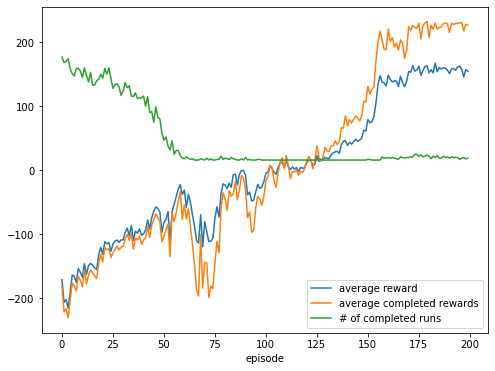

In [7]:
import matplotlib.pyplot as plt

rewards, completed_rewards, losses, clip_losses, v_losses, h_losses, completed_runs, none_completed_runs = zip(*ep_logs)

fig = plt.figure(figsize=(8,6))
plt.plot(rewards, label='average reward')
plt.plot(completed_rewards, label='average completed rewards')
plt.plot(completed_runs, label='# of completed runs')
plt.xlabel('episode')
plt.legend()
plt.show()
save_plot(fig, 'ppo_rewards')

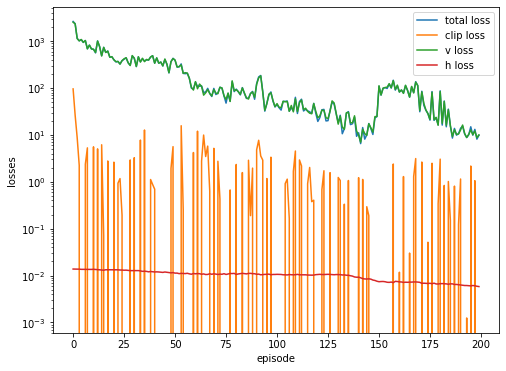

In [8]:
fig = plt.figure(figsize=(8,6))
plt.plot(losses, label='total loss')
plt.plot(clip_losses, label='clip loss')
plt.plot(v_losses, label='v loss')
plt.plot(h_losses, label='h loss')
plt.xlabel('episode')
plt.ylabel('losses')
plt.yscale('log', base=10)
plt.legend()
plt.show()
save_plot(fig, 'ppo_losses')


In [9]:
from gymnasium.wrappers.monitoring import video_recorder
import os

path = 'videos'
os.makedirs(path, exist_ok = True) 

# record video of the result
env = gym.make("LunarLander-v2", render_mode="rgb_array")
video = video_recorder.VideoRecorder(env, path=f'{path}/video_ppo.mp4')
state, _ = env.reset(seed=SEED)
while True:
    video.capture_frame()

    # next action
    with torch.no_grad():
        action = policy.action_prob(torch.tensor(state, device=device))[0].item()

    state, _, terminated, truncated, _ = env.step(action)
    if terminated or truncated: break
video.close()
env.close()

Moviepy - Building video videos/video_ppo.mp4.
Moviepy - Writing video videos/video_ppo.mp4



Moviepy - Done !
Moviepy - video ready videos/video_ppo.mp4
